# ISIC 2019 Skin Lesion Detection


This notebook creates an ML model to predict the probability of 9 different skin lesion classes:

1. Melanoma
2. Melanocytic nevus
3. Basal cell carcinoma
4. Actinic keratosis
5. Benign keratosis (solar lentigo / seborrheic keratosis / lichen planus-like keratosis)
6. Dermatofibroma
7. Vascular lesion
8. Squamous cell carcinoma
9. None of the others

Data for this notebook is sourced from the ISIC 2019 Skin Lesion competition (https://challenge2019.isic-archive.com/data.html), and has been preprocessed using ISIC_processing.py

The Backend model used is DenseNet169 with 'imagenet' weights. Built ontop of this is 5 convolutional blocks and 5 fully connected blocks. 

The model has a mean average precision (mAP) of ~61% across all classes.

## Load Libraries and Data

In [0]:
# Import Libraries
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt

In [2]:
# Directory Setup
size = 'medium_size'
main_dir = '/content/drive/My Drive/ISIC'
datasets = os.path.join(main_dir, 'datasets/')

# Load Data
x_train = np.load(os.path.join(datasets, size, 'train_img.npy'))
y_train = np.load(os.path.join(datasets, size, 'train_gt.npy'))
classes = ['MEL','NV','BCC','AK','BKL','DF','VASC','SCC','UNK']

# Print Shapes
print('Training Images Shape: ', x_train.shape)
print('Training GT Shape: ', y_train.shape)

Training Images Shape:  (25331, 224, 224, 3)
Training GT Shape:  (25331, 9)


## Build Model

In [0]:
# Import Libraries
from tensorflow.keras.layers import Conv2D, Reshape, BatchNormalization, Dropout, LeakyReLU, Dense, GlobalAveragePooling2D, Flatten, MaxPool2D
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.models import Sequential

In [0]:
def model(num_classes):
  """ DOC STRING """

  # Generate Model
  model = Sequential()

  # Load DenseNet169
  model.add(DenseNet169(weights = 'imagenet', include_top = False))
  
  # Build ConvNet to Detect Text In Images

  # CONV Block
  model.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', kernel_initializer=initializer))
  model.add(Dropout(0.25))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.3))

  # CONV Block
  model.add(Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', kernel_initializer=initializer))
  model.add(Dropout(0.25))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.3))
 
  # CONV Block
  model.add(Conv2D(512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', kernel_initializer=initializer))
  model.add(Dropout(0.25))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.3))

  # CONV Block
  model.add(Conv2D(1024, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', kernel_initializer=initializer))
  model.add(Dropout(0.25))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.3))

  # CONV Block
  model.add(Conv2D(2048, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', kernel_initializer=initializer))
  model.add(Dropout(0.25))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.3))

  # Final Conv
  model.add(Conv2D(filters=num_classes, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', kernel_initializer=initializer))
  model.add(LeakyReLU(alpha=0.3))
  model.add(GlobalAveragePooling2D())

  # FC Layer
  model.add(Dense(120, activation='relu'))
  model.add(Dense(84, activation='relu'))
  model.add(Dense(60, activation='relu'))
  model.add(Dense(60, activation='relu'))
  model.add(Dense(9, activation='softmax'))

  # Freeze DenseNet169 Layers
  model.layers[0].trainable = False


  return model

## Train Model

In [0]:
# TRAINING
# Import Libraries
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

In [6]:
# Create new folder
callback_dir = os.path.join(main_dir, 'callbacks/')
today = datetime.now()                    # Get Runtime
today = today.strftime('%Y%m%d%H%M%S')    # Convert to folder string
callback_path = callback_dir + today + '/'

os.mkdir(callback_path)                   # Create new folder for callbacks

# Checkpoint
checkpoint = ModelCheckpoint(callback_path, 
                             monitor = 'val_accuracy', 
                             verbose=1, 
                             save_best_only=True,
                             save_weights_only=True, 
                             mode='min')

# Define Initializer
initializer = tf.keras.initializers.glorot_normal(seed=23)

# Build Model
num_classes = 9
model = model(num_classes=num_classes)

# Define Optimizer
adam = Adam(learning_rate=0.000001, 
            beta_1=0.9, 
            beta_2=0.999, 
            epsilon=1e-08, 
            amsgrad=True)

# Load Weights
model.load_weights(main_dir + '/model_weights_densenet_with_processing_3.h5')

# Compile Model
model.compile(optimizer=adam, 
              loss=CategoricalCrossentropy(), 
              metrics=['accuracy'])

51879936/51877672 [==============================] - 1s 0us/step


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Model)          (None, None, None, 1664)  12642880  
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 128)   1917056   
_________________________________________________________________
dropout (Dropout)            (None, None, None, 128)   0         
_________________________________________________________________
batch_normalization (BatchNo (None, None, None, 128)   512       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, None, None, 128)   0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 256)   295168    
_________________________________________________________________
dropout_1 (Dropout)          (None, None, None, 256)   0

In [8]:
# Load train_test_split from sklearn
from sklearn.model_selection import train_test_split

# Split Data
x_train, x_validate, y_train, y_validate = train_test_split(x_train, 
                                                            y_train, 
                                                            shuffle=True,
                                                            stratify=y_train, 
                                                            test_size=0.1, 
                                                            random_state=23)

print('Train Size: ', len(x_train))
print('Validate Size: ', len(x_validate))

Train Size:  22797
Validate Size:  2534


In [9]:
# Training Set Distribution
unq_rows, count = np.unique(y_train,axis=0, return_counts=1)
out = {tuple(i):j for i,j in zip(unq_rows,count)}
print('Training Labels')
out

Training Labels


{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0): 565,
 (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0): 228,
 (0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0): 215,
 (0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0): 2361,
 (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0): 780,
 (0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0): 2991,
 (0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0): 11587,
 (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0): 4070}

In [10]:
# Validation Set Distribution
unq_rows, count = np.unique(y_validate,axis=0, return_counts=1)
out = {tuple(i):j for i,j in zip(unq_rows,count)}
print('Validate Labels')
out

Validate Labels


{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0): 63,
 (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0): 25,
 (0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0): 24,
 (0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0): 263,
 (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0): 87,
 (0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0): 332,
 (0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0): 1288,
 (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0): 452}

In [11]:
history = model.fit(x=x_train, 
                    y=y_train, 
                    epochs=10, 
                    batch_size=64, 
                    callbacks=[checkpoint], 
                    shuffle=True, 
                    validation_data=(x_validate, y_validate))

Epoch 1/10
357/357 [==============================] - ETA: 0s - loss: 0.4639 - accuracy: 0.8373
Epoch 00001: val_accuracy improved from inf to 0.67009, saving model to /content/drive/My Drive/ISIC/callbacks/20200513152551/
357/357 [==============================] - 70s 196ms/step - loss: 0.4639 - accuracy: 0.8373 - val_loss: 1.0336 - val_accuracy: 0.6701
Epoch 2/10
357/357 [==============================] - ETA: 0s - loss: 0.4508 - accuracy: 0.8427
Epoch 00002: val_accuracy did not improve from 0.67009
357/357 [==============================] - 63s 176ms/step - loss: 0.4508 - accuracy: 0.8427 - val_loss: 1.0383 - val_accuracy: 0.6728
Epoch 3/10
357/357 [==============================] - ETA: 0s - loss: 0.4459 - accuracy: 0.8429
Epoch 00003: val_accuracy did not improve from 0.67009
357/357 [==============================] - 63s 176ms/step - loss: 0.4459 - accuracy: 0.8429 - val_loss: 1.0370 - val_accuracy: 0.6744
Epoch 4/10
357/357 [==============================] - ETA: 0s - loss: 0.4

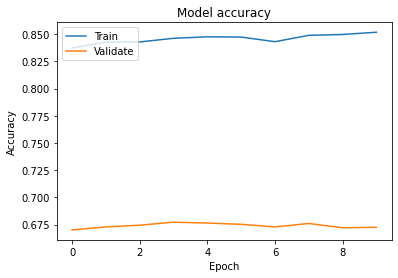

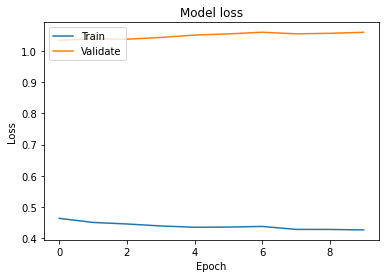

In [12]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

## Model Metrics

In [0]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

preds = model.predict(x_validate)

In [0]:
arg_max_preds = np.argmax(preds, axis=1)
arg_max_true = np.argmax(y_validate, axis=1)
accuracy = accuracy_score(arg_max_true, arg_max_preds)
conf_mat = confusion_matrix(arg_max_true, arg_max_preds)

In [15]:
accuracy

0.6724546172059984

In [16]:
conf_mat

array([[ 124,  192,   41,    9,   79,    0,    2,    5],
       [  30, 1137,   48,    2,   57,    0,   13,    1],
       [   2,   30,  262,    7,   20,    0,    6,    5],
       [   0,    6,   27,   27,   24,    0,    1,    2],
       [   8,   87,   34,    6,  126,    1,    1,    0],
       [   1,    8,    9,    0,    3,    1,    2,    0],
       [   0,    4,    3,    0,    1,    0,   17,    0],
       [   2,   10,   32,    1,    7,    0,    1,   10]])

In [0]:
model.save(main_dir + '/model_weights_densenet.h5')

In [18]:
arg_max_preds

array([1, 0, 1, ..., 1, 1, 0])

In [19]:
y_validate

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

## Model Evaluation

Evaluation

In [0]:
def find_stats(preds: list, y_true: list, label: int) -> int:
  ''' '''
  tp = 0
  tn = 0
  fp = 0
  fn = 0
  if len(preds) != len(y_true):
    raise ValueError('preds and y_true different lengths')

  else:
    arg_max_preds = np.argmax(preds, axis=1)
    arg_max_true = np.argmax(y_true, axis=1)

    for i in range(len(arg_max_preds)):
      if (arg_max_preds[i] == label) and (arg_max_preds[i] == label):
        tp += 1
      if (arg_max_preds[i] == label) and (arg_max_true[i] != label):
        fp += 1
      if (arg_max_preds[i] != label) and (arg_max_true[i] == label):
        fn += 1
      if (arg_max_preds[i] != label) and (arg_max_true[i] != label):
        tn += 1

    return tp, tn, fp, fn

In [21]:
stats = []
for i in range(num_classes):
  tp, tn, fp, fn = find_stats(preds=preds, y_true=y_validate, label=i)
  stats.append([tp, tn, fp, fn])

print(stats)

[[167, 2039, 43, 328], [1474, 909, 337, 151], [456, 2008, 194, 70], [52, 2422, 25, 60], [317, 2080, 191, 137], [2, 2509, 1, 23], [43, 2483, 26, 8], [23, 2458, 13, 53], [0, 2534, 0, 0]]


In [22]:
# Sensitivity --> TP / (TP + FN)
sensitivity = []
for i in range(len(stats)):
  if (stats[i][0] == 0) and (stats[i][3] == 0):
    sensitivity.append(0)
  else:
    sens = stats[i][0] / (stats[i][0] + stats[i][3])
    sensitivity.append(sens)

for i in range(len(stats)):
  print('Sensitivity of Class {:4} : {}'.format(classes[i], sensitivity[i]))

Sensitivity of Class MEL  : 0.3373737373737374
Sensitivity of Class NV   : 0.9070769230769231
Sensitivity of Class BCC  : 0.8669201520912547
Sensitivity of Class AK   : 0.4642857142857143
Sensitivity of Class BKL  : 0.698237885462555
Sensitivity of Class DF   : 0.08
Sensitivity of Class VASC : 0.8431372549019608
Sensitivity of Class SCC  : 0.3026315789473684
Sensitivity of Class UNK  : 0


In [23]:
# Specificity --> TN / (TN + FP)
specificity = []
for i in range(len(stats)):
  if (stats[i][1] == 0) and (stats[i][2] == 0):
    specificity.append(0)
  else:
    sens = stats[i][1] / (stats[i][1] + stats[i][2])
    specificity.append(sens)

for i in range(len(stats)):
  print('Specificity of Class {:4} : {}'.format(classes[i], specificity[i]))

Specificity of Class MEL  : 0.9793467819404419
Specificity of Class NV   : 0.7295345104333868
Specificity of Class BCC  : 0.9118982742960945
Specificity of Class AK   : 0.9897834082550061
Specificity of Class BKL  : 0.9158960810215764
Specificity of Class DF   : 0.999601593625498
Specificity of Class VASC : 0.9896373056994818
Specificity of Class SCC  : 0.9947389720760825
Specificity of Class UNK  : 1.0


In [24]:
# Accuracy --> (TP + TN) / (TP + TN + FP + FN)
acc = []
for i in range(len(stats)):
  acc_val = (stats[i][0] + stats[i][1]) / (stats[i][0] + stats[i][1] + stats[i][2] + stats[i][3])
  acc.append(acc_val)

for i in range(len(stats)):
  print('Accuracy of Class {:4} : {}'.format(classes[i], acc[i]))

Accuracy of Class MEL  : 0.8560341482343811
Accuracy of Class NV   : 0.8300243817485197
Accuracy of Class BCC  : 0.9032258064516129
Accuracy of Class AK   : 0.9667838999609223
Accuracy of Class BKL  : 0.8796330275229358
Accuracy of Class DF   : 0.9905325443786982
Accuracy of Class VASC : 0.98671875
Accuracy of Class SCC  : 0.9740871613663133
Accuracy of Class UNK  : 1.0


In [25]:
# Positive Predicted Value --> TP / (TP + FP)
ppv = []
for i in range(len(stats)):
  if (stats[i][0] == 0) and (stats[i][2] == 0):
    ppv.append(0)
  else:
    ppv_ = stats[i][0] / (stats[i][0] + stats[i][2])
    ppv.append(ppv_)

for i in range(len(stats)):
  print('Positive Predicted Value of Class {:4} : {}'.format(classes[i], ppv[i]))

Positive Predicted Value of Class MEL  : 0.7952380952380952
Positive Predicted Value of Class NV   : 0.8139149641082275
Positive Predicted Value of Class BCC  : 0.7015384615384616
Positive Predicted Value of Class AK   : 0.6753246753246753
Positive Predicted Value of Class BKL  : 0.6240157480314961
Positive Predicted Value of Class DF   : 0.6666666666666666
Positive Predicted Value of Class VASC : 0.6231884057971014
Positive Predicted Value of Class SCC  : 0.6388888888888888
Positive Predicted Value of Class UNK  : 0


In [26]:
# Negative Predicted Value --> TN / (TN + FN)
npv = []
for i in range(len(stats)):
  if (stats[i][1] == 0) and (stats[i][3] == 0):
    npv.append(0)
  else:
    npv_ = stats[i][1] / (stats[i][1] + stats[i][3])
    npv.append(npv_)

for i in range(len(stats)):
  print('Negative Predicted Value of Class {:4} : {}'.format(classes[i], npv[i]))

Negative Predicted Value of Class MEL  : 0.8614279678918462
Negative Predicted Value of Class NV   : 0.8575471698113207
Negative Predicted Value of Class BCC  : 0.9663137632338787
Negative Predicted Value of Class AK   : 0.975825946817083
Negative Predicted Value of Class BKL  : 0.9382047812359043
Negative Predicted Value of Class DF   : 0.990916271721959
Negative Predicted Value of Class VASC : 0.9967884383781613
Negative Predicted Value of Class SCC  : 0.9788928713659897
Negative Predicted Value of Class UNK  : 1.0


In [27]:
# Mean Average Precision (mAP)
total = 0
for i in range(len(ppv)):
  total += ppv[i]
mAP = total / len(ppv)
print('The mAP is ', mAP)

The mAP is  0.6154195450659571


In [28]:
# F1 Score --> (2 * ((PPV * Sensitivity) / (PPV + Sensitivity)))
f1 = []
for i in range(len(stats)):
  if ppv[i] == 0 and sensitivity[i] == 0:
    f1.append(0)
  else:
    f1_ = 2 * ((ppv[i] * sensitivity[i]) / (ppv[i] + sensitivity[i]))
    f1.append(f1_)

for i in range(len(stats)):
  print('F1-Score of Class {:4} : {}'.format(classes[i], f1[i]))

F1-Score of Class MEL  : 0.47375886524822697
F1-Score of Class NV   : 0.8579743888242143
F1-Score of Class BCC  : 0.7755102040816326
F1-Score of Class AK   : 0.5502645502645503
F1-Score of Class BKL  : 0.659043659043659
F1-Score of Class DF   : 0.14285714285714285
F1-Score of Class VASC : 0.7166666666666667
F1-Score of Class SCC  : 0.4107142857142857
F1-Score of Class UNK  : 0
